In [10]:
# ============================
# Cell 1 — Imports + Env (Pendulum-v1)
#   State we use internally: (theta, omega)
#   Obs from env: [cos(theta), sin(theta), omega]
# ============================

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.*", category=UserWarning)

import os
import time
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from PIL import Image

import gymnasium as gym

# GP / TF stack (same as your MountainCar)
import tensorflow as tf
import gpflow
from gpflow.inducing_variables import InducingPoints


gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")

print("TF version:", tf.__version__)
print("GPflow version:", gpflow.__version__)

# ----------------------------
# Pendulum constants
# ----------------------------
ENV_NAME = "Pendulum-v1"
U_MIN, U_MAX = -2.0, 2.0

# For angle wrapping
def wrap_pi(theta):
    """Wrap angle to (-pi, pi]."""
    return (theta + np.pi) % (2.0 * np.pi) - np.pi

def obs_to_theta_omega(obs):
    """
    Pendulum obs: [cos(theta), sin(theta), omega]
    Return:
        theta in (-pi, pi]
        omega (rad/s)
    """
    c, s, w = float(obs[0]), float(obs[1]), float(obs[2])
    theta = math.atan2(s, c)
    theta = wrap_pi(theta)
    return theta, w

def theta_omega_to_features(theta, omega, u, omega_scale=8.0):
    """
    GP input features (your style):
      X = [sin(theta), cos(theta), omega_feat, u]
      omega_feat = tanh(omega / omega_scale)
    """
    omega_feat = np.tanh(float(omega) / float(omega_scale))
    return np.array([np.sin(theta), np.cos(theta), omega_feat, float(u)], dtype=np.float64)

# ----------------------------
# Env builder
# ----------------------------
def make_env(render_mode=None, seed=0):
    """
    render_mode:
      None -> fastest
      "rgb_array" -> for recording/animation
      "human" -> live window
    """
    env = gym.make(ENV_NAME, render_mode=render_mode)
    env.reset(seed=seed)
    return env

# Quick sanity check
env_test = make_env(render_mode=None, seed=0)
obs, info = env_test.reset()
theta0, omega0 = obs_to_theta_omega(obs)
print("Sanity check:")
print("  obs:", obs)
print("  theta0:", theta0, "omega0:", omega0)
env_test.close()


TF version: 2.20.0
GPflow version: 2.10.0
Sanity check:
  obs: [-0.9670439  -0.25460985 -0.96694475]
  theta0: -2.8841484195361597 omega0: -0.9669447541236877


In [11]:
# ============================
# Cell 2 — Smooth rendered rollout widget (rgb_array -> JS HTML)
#   - Works like your MountainCar live demo
#   - Uses rgb_array frames + resize + stride for smoothness
# ============================

def _encode_frames_to_jshtml(frames, fps=20):
    """
    frames: list of HxWx3 uint8 images
    """
    fig = plt.figure(figsize=(frames[0].shape[1] / 120, frames[0].shape[0] / 120), dpi=120)
    plt.axis("off")
    im = plt.imshow(frames[0])

    def _update(i):
        im.set_data(frames[i])
        return (im,)

    ani = animation.FuncAnimation(fig, _update, frames=len(frames), interval=1000 / fps, blit=True)
    plt.close(fig)
    return HTML(ani.to_jshtml())

def rollout_render_widget(
    env,
    policy_fn,
    steps=300,
    seed=0,
    frame_stride=1,
    resize=(720, 450),
    quality=80,
    fps=20,
    verbose=True,
):
    """
    Render a rollout using env.render() rgb_array frames.
    policy_fn(theta, omega, t) -> action u in [U_MIN, U_MAX]
    """
    obs, info = env.reset(seed=seed)
    theta, omega = obs_to_theta_omega(obs)

    frames = []
    total_reward = 0.0

    for t in range(steps):
        u = float(policy_fn(theta, omega, t))
        u = np.clip(u, U_MIN, U_MAX)

        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        total_reward += float(r)

        theta2, omega2 = obs_to_theta_omega(obs2)

        if (t % frame_stride) == 0:
            frame = env.render()
            if frame is not None:
                img = Image.fromarray(frame)
                img = img.resize(resize, resample=Image.BILINEAR)
                frames.append(np.array(img))

        theta, omega = theta2, omega2

        if terminated or truncated:
            break

    if verbose:
        print(f"Rollout done. steps={t+1}, total_reward={total_reward:.3f}, frames={len(frames)}")

    if len(frames) == 0:
        print("No frames captured (did you set render_mode='rgb_array'?)")
        return None

    return _encode_frames_to_jshtml(frames, fps=fps)

# ----------------------------
# Example: random demo policy
# ----------------------------
def random_policy(theta, omega, t):
    return np.random.uniform(U_MIN, U_MAX)

# Quick demo (rgb_array mode)
env_demo = make_env(render_mode="rgb_array", seed=0)
html = rollout_render_widget(
    env_demo,
    policy_fn=random_policy,
    steps=250,
    seed=0,
    frame_stride=1,
    resize=(720, 450),
    quality=80,
    fps=20,
)
env_demo.close()
display(html)


Rollout done. steps=200, total_reward=-1062.639, frames=200


Initial random data collected:
  X0    : (10, 4)   (sinθ, cosθ, ω_feat, u)
  Ydth0 : (10, 1)
  Ydom0 : (10, 1)
  omega_scale = 4.95050845010376
  steps = 10 total_reward = -25.166023247291555


Saved: pendulum_gp_initial_data.npz


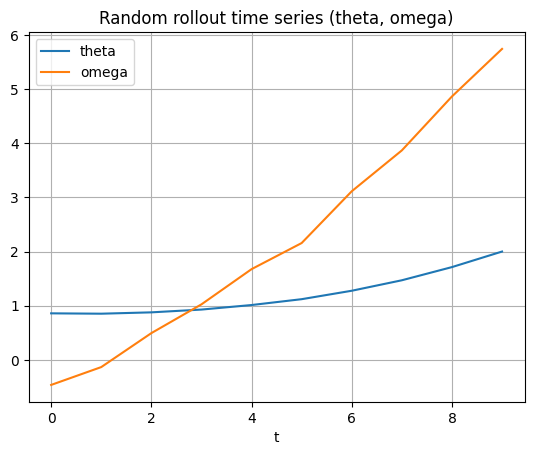

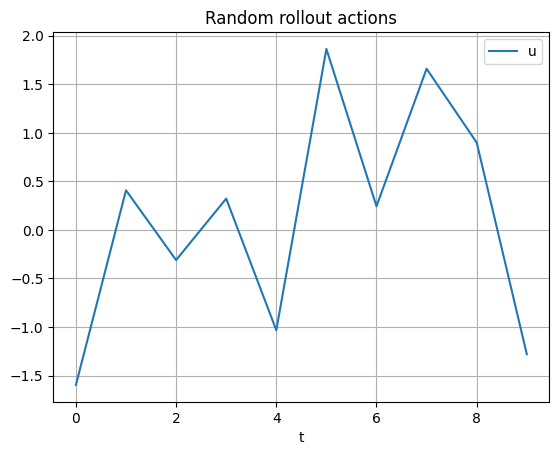

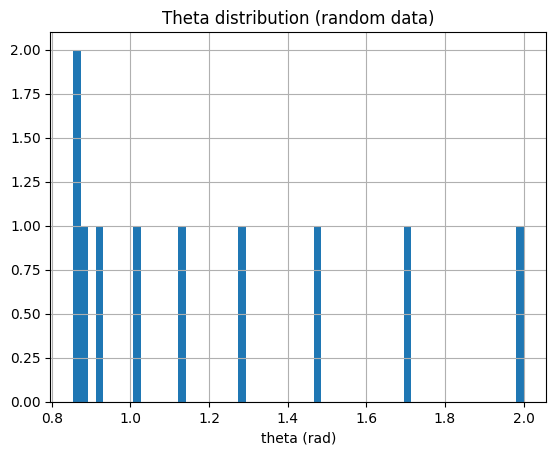

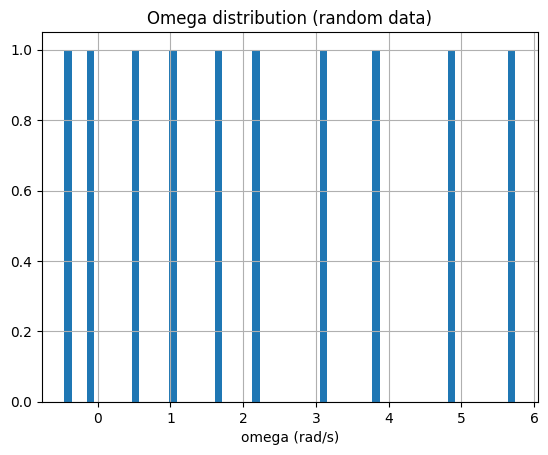

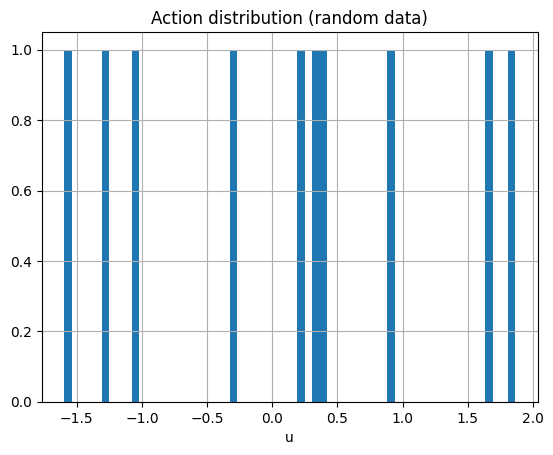

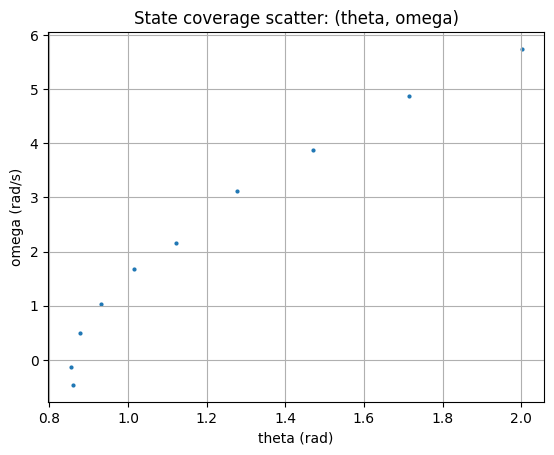

In [12]:
# ============================
# Cell 3 — Random data collection (executed transitions only) + plots
#   Dataset:
#     X      = [sin(theta), cos(theta), omega_feat, u]
#     Yθ     = dtheta  (wrapped)
#     Yω     = domega
# ============================

def collect_random_transitions(
    steps=2000,
    seed=0,
    render=False,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
):
    """
    Collect random rollouts from real env transitions (executed labels only).
    Returns:
        X      (N,4)
        Ydth   (N,1)
        Ydom   (N,1)
        omega_scale (float)
        debug dict (theta, omega, u histories)
        html (optional)  # only if render=True
    """
    # choose env mode
    env = make_env(render_mode="rgb_array" if render else None, seed=seed)

    obs, info = env.reset(seed=seed)
    theta, omega = obs_to_theta_omega(obs)

    # histories for debug/plots
    thetas = []
    omegas = []
    actions = []

    # raw transition storage (we’ll build features later once omega_scale is decided)
    theta_list = []
    omega_list = []
    u_list     = []
    dtheta_list = []
    domega_list = []

    frames = []
    total_reward = 0.0

    for t in range(steps):
        u = np.random.uniform(U_MIN, U_MAX)

        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        total_reward += float(r)

        theta2, omega2 = obs_to_theta_omega(obs2)

        # executed transition deltas
        dtheta = wrap_pi(theta2 - theta)
        domega = float(omega2 - omega)

        thetas.append(theta)
        omegas.append(omega)
        actions.append(u)

        theta_list.append(theta)
        omega_list.append(omega)
        u_list.append(u)
        dtheta_list.append(dtheta)
        domega_list.append(domega)

        if render and (t % frame_stride == 0):
            frame = env.render()
            if frame is not None:
                img = Image.fromarray(frame).resize(resize, resample=Image.BILINEAR)
                frames.append(np.array(img))

        theta, omega = theta2, omega2

        if terminated or truncated:
            break

    env.close()

    # -------- choose omega_scale from collected data --------
    omega_arr = np.array(omega_list, dtype=np.float64)
    omega_scale = float(np.percentile(np.abs(omega_arr), 90) + 1e-6)
    omega_scale = max(omega_scale, 4.0)  # keep a sane minimum

    # -------- build X features with the chosen omega_scale --------
    X = []
    for th, om, u in zip(theta_list, omega_list, u_list):
        X.append(theta_omega_to_features(th, om, u, omega_scale=omega_scale))
    X = np.array(X, dtype=np.float64)

    Ydth = np.array(dtheta_list, dtype=np.float64).reshape(-1, 1)
    Ydom = np.array(domega_list, dtype=np.float64).reshape(-1, 1)

    debug = dict(
        theta=np.array(thetas, dtype=np.float64),
        omega=np.array(omegas, dtype=np.float64),
        u=np.array(actions, dtype=np.float64),
        total_reward=total_reward,
        steps=len(theta_list),
    )

    html = None
    if render and len(frames) > 0:
        html = _encode_frames_to_jshtml(frames, fps=fps)

    return X, Ydth, Ydom, omega_scale, debug, html


# ----------------------------
# Collect initial dataset
# ----------------------------
N_RANDOM = 10
X0, Ydth0, Ydom0, omega_scale, dbg0, html0 = collect_random_transitions(
    steps=N_RANDOM,
    seed=0,
    render=True,          # set False for speed
    frame_stride=1,
    resize=(720, 450),
    fps=20,
)

print("Initial random data collected:")
print("  X0    :", X0.shape, "  (sinθ, cosθ, ω_feat, u)")
print("  Ydth0 :", Ydth0.shape)
print("  Ydom0 :", Ydom0.shape)
print("  omega_scale =", omega_scale)
print("  steps =", dbg0["steps"], "total_reward =", dbg0["total_reward"])

if html0 is not None:
    display(html0)

# ----------------------------
# Save (same habit as your MountainCar notebook)
# ----------------------------
np.savez(
    "pendulum_gp_initial_data.npz",
    X=X0,
    Ydtheta=Ydth0,
    Ydomega=Ydom0,
    omega_scale=np.array([omega_scale], dtype=np.float64),
)
print("Saved: pendulum_gp_initial_data.npz")

# ----------------------------
# Plots — distribution + time series
# ----------------------------
theta_hist = dbg0["theta"]
omega_hist = dbg0["omega"]
u_hist     = dbg0["u"]

plt.figure()
plt.plot(theta_hist, label="theta")
plt.plot(omega_hist, label="omega")
plt.title("Random rollout time series (theta, omega)")
plt.xlabel("t")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(u_hist, label="u")
plt.title("Random rollout actions")
plt.xlabel("t")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.hist(theta_hist, bins=60)
plt.title("Theta distribution (random data)")
plt.xlabel("theta (rad)")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(omega_hist, bins=60)
plt.title("Omega distribution (random data)")
plt.xlabel("omega (rad/s)")
plt.grid(True)
plt.show()

plt.figure()
plt.hist(u_hist, bins=60)
plt.title("Action distribution (random data)")
plt.xlabel("u")
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(theta_hist, omega_hist, s=4)
plt.title("State coverage scatter: (theta, omega)")
plt.xlabel("theta (rad)")
plt.ylabel("omega (rad/s)")
plt.grid(True)
plt.show()


In [13]:
# ===========================
# Cell 4 — Streaming OSGPR (VFE) — paper-style regression update (D-dim input)
#   Works for Pendulum input x=[sinθ, cosθ, ω_feat, u] (D=4)
#   Single-output GP (we train two models: dtheta and domega)
#   ✅ Includes caching for VERY fast predict (needed for MPPI)
# ===========================

import time
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.inducing_variables import InducingPoints
from gpflow.models import GPModel, InternalDataTrainingLossMixin
from gpflow import covariances

# --- stable numerics ---
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")


# ---------------------------
# helpers
# ---------------------------
def sym_jitter(A, jitter=1e-6):
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    A = A + jitter * np.eye(A.shape[0], dtype=np.float64)
    return A

def finite_mask(*arrs):
    m = None
    for a in arrs:
        a = np.asarray(a)
        mm = np.isfinite(a).all(axis=1) if a.ndim == 2 else np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m

def choose_inducing_keep_old(Z_old, X_new, M, keep_frac=0.8, rng=None):
    """
    D-dimensional inducing management:
      keep_frac of old inducing points + rest from current batch.
    Z_old: (M_old, D)
    X_new: (N_new, D)
    """
    if rng is None:
        rng = np.random.default_rng(0)

    Z_old = np.asarray(Z_old, dtype=np.float64)
    X_new = np.asarray(X_new, dtype=np.float64)

    assert Z_old.ndim == 2 and X_new.ndim == 2
    D = Z_old.shape[1]
    assert X_new.shape[1] == D, f"Dim mismatch: Z_old D={D}, X_new D={X_new.shape[1]}"

    M_keep = int(np.round(M * keep_frac))
    M_new  = M - M_keep
    M_keep = min(M_keep, Z_old.shape[0])
    M_new  = min(M_new,  X_new.shape[0])

    old_idx = rng.choice(Z_old.shape[0], size=M_keep, replace=False) if M_keep > 0 else np.array([], dtype=int)
    new_idx = rng.choice(X_new.shape[0], size=M_new,  replace=False) if M_new  > 0 else np.array([], dtype=int)

    Z = np.vstack([Z_old[old_idx], X_new[new_idx]]).astype(np.float64)

    if Z.shape[0] < M:
        need = M - Z.shape[0]
        extra = rng.choice(X_new.shape[0], size=need, replace=True)
        Z = np.vstack([Z, X_new[extra]])
    return Z


# ============================================================
# OSGPR-VFE model (Bui et al., NIPS 2017) — VFE case
# ============================================================
class OSGPR_VFE(GPModel, InternalDataTrainingLossMixin):
    """
    Online Sparse Variational GP Regression (VFE), regression-only.
    SINGLE-OUTPUT. Train two models for dtheta and domega.

    ✅ Includes prediction cache for fast MPPI:
      - build_predict_cache()
      - predict_f_cached()
    """

    def __init__(self, data, kernel, mu_old, Su_old, Kaa_old, Z_old, Z, mean_function=None):
        X, Y = gpflow.models.util.data_input_to_tensor(data)
        self.X, self.Y = X, Y
        likelihood = gpflow.likelihoods.Gaussian()
        num_latent_gps = GPModel.calc_num_latent_gps_from_data(data, kernel, likelihood)
        super().__init__(kernel, likelihood, mean_function, num_latent_gps)

        Z = np.asarray(Z, dtype=np.float64)
        assert Z.ndim == 2, "Z must be (M, D)"
        self.inducing_variable = InducingPoints(Z)
        self.num_data = tf.shape(self.X)[0]

        # old summary (fixed)
        mu_old  = np.asarray(mu_old, dtype=np.float64).reshape(-1, 1)
        Su_old  = sym_jitter(Su_old, 1e-6)
        Kaa_old = sym_jitter(Kaa_old, 1e-6)
        Z_old   = np.asarray(Z_old, dtype=np.float64)
        assert Z_old.ndim == 2, "Z_old must be (M_old, D)"

        self.mu_old  = tf.Variable(mu_old,  trainable=False, dtype=gpflow.default_float())
        self.Su_old  = tf.Variable(Su_old,  trainable=False, dtype=gpflow.default_float())
        self.Kaa_old = tf.Variable(Kaa_old, trainable=False, dtype=gpflow.default_float())
        self.Z_old   = tf.Variable(Z_old,   trainable=False, dtype=gpflow.default_float())

        if self.mean_function is None:
            self.mean_function = gpflow.mean_functions.Zero()

        # cache state
        self._cache_ready = False
        self._cache_Lb = None
        self._cache_LD = None
        self._cache_rhs = None

    def _common_terms(self):
        Mb = self.inducing_variable.num_inducing
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance

        Saa = self.Su_old
        ma  = self.mu_old

        # Kbf, Kbb, Kba, Kaa (old)
        Kbf = covariances.Kuf(self.inducing_variable, self.kernel, self.X)                # [Mb, N]
        Kbb = covariances.Kuu(self.inducing_variable, self.kernel, jitter=jitter)         # [Mb, Mb]
        Kba = covariances.Kuf(self.inducing_variable, self.kernel, self.Z_old)            # [Mb, Ma]

        # current kernel at Z_old (optional mismatch correction term)
        Kaa_cur = gpflow.utilities.add_noise_cov(self.kernel(self.Z_old), jitter)         # current kernel(Z_old,Z_old)
        Kaa = gpflow.utilities.add_noise_cov(self.Kaa_old, jitter)                        # stored old kernel(Z_old,Z_old)

        err = self.Y - self.mean_function(self.X)

        # c = Kbf * (Y/sigma2) + Kba * (Saa^{-1} ma)
        Sainv_ma = tf.linalg.solve(Saa, ma)
        c1 = tf.matmul(Kbf, self.Y / sigma2)                                              # [Mb,1]
        c2 = tf.matmul(Kba, Sainv_ma)                                                     # [Mb,1]
        c  = c1 + c2                                                                      # [Mb,1]

        # Cholesky(Kbb)
        Lb = tf.linalg.cholesky(Kbb)
        Lbinv_c   = tf.linalg.triangular_solve(Lb, c, lower=True)
        Lbinv_Kba = tf.linalg.triangular_solve(Lb, Kba, lower=True)
        Lbinv_Kbf = tf.linalg.triangular_solve(Lb, Kbf, lower=True) / tf.sqrt(sigma2)

        d1 = tf.matmul(Lbinv_Kbf, Lbinv_Kbf, transpose_b=True)                            # [Mb,Mb]

        # d2 = (LSa^{-1} Kab Lb^{-1})^T (LSa^{-1} Kab Lb^{-1})
        LSa = tf.linalg.cholesky(Saa)
        Kab_Lbinv = tf.linalg.matrix_transpose(Lbinv_Kba)                                 # [Ma,Mb]
        LSainv_Kab_Lbinv = tf.linalg.triangular_solve(LSa, Kab_Lbinv, lower=True)
        d2 = tf.matmul(LSainv_Kab_Lbinv, LSainv_Kab_Lbinv, transpose_a=True)

        # d3 = (La^{-1} Kab Lb^{-1})^T (La^{-1} Kab Lb^{-1})
        La = tf.linalg.cholesky(Kaa)
        Lainv_Kab_Lbinv = tf.linalg.triangular_solve(La, Kab_Lbinv, lower=True)
        d3 = tf.matmul(Lainv_Kab_Lbinv, Lainv_Kab_Lbinv, transpose_a=True)

        # D = I + d1 + d2 - d3
        D = tf.eye(Mb, dtype=gpflow.default_float()) + d1 + d2 - d3
        D = gpflow.utilities.add_noise_cov(D, jitter)
        LD = tf.linalg.cholesky(D)

        LDinv_Lbinv_c = tf.linalg.triangular_solve(LD, Lbinv_c, lower=True)

        # Qff_diag term for trace: diag(Kfb Kbb^{-1} Kbf) / sigma2
        Qff_diag = tf.reduce_sum(tf.square(Lbinv_Kbf), axis=0)                             # [N]

        return (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
                Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag)

    def maximum_log_likelihood_objective(self):
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance
        N = tf.cast(self.num_data, gpflow.default_float())

        Saa = self.Su_old
        ma  = self.mu_old

        Kfdiag = self.kernel(self.X, full_cov=False)

        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        # ma term
        LSa = tf.linalg.cholesky(Saa)
        Lainv_ma = tf.linalg.triangular_solve(LSa, ma, lower=True)

        bound = -0.5 * N * np.log(2.0 * np.pi)
        bound += -0.5 * tf.reduce_sum(tf.square(err)) / sigma2
        bound += -0.5 * tf.reduce_sum(tf.square(Lainv_ma))
        bound +=  0.5 * tf.reduce_sum(tf.square(LDinv_Lbinv_c))

        bound += -0.5 * N * tf.math.log(sigma2)
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LD)))

        bound += -0.5 * tf.reduce_sum(Kfdiag) / sigma2
        bound +=  0.5 * tf.reduce_sum(Qff_diag)

        bound += tf.reduce_sum(tf.math.log(tf.linalg.diag_part(La)))
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LSa)))

        Kaadiff = Kaa_cur - tf.matmul(Lbinv_Kba, Lbinv_Kba, transpose_a=True)
        Sainv_Kaadiff = tf.linalg.solve(Saa, Kaadiff)
        Kainv_Kaadiff = tf.linalg.solve(Kaa, Kaadiff)

        bound += -0.5 * tf.reduce_sum(
            tf.linalg.diag_part(Sainv_Kaadiff) - tf.linalg.diag_part(Kainv_Kaadiff)
        )
        return bound

    def predict_f(self, Xnew, full_cov=False):
        # slow but correct; cached version below is used in MPPI
        jitter = gpflow.utilities.to_default_float(1e-6)

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)
        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_c, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=gpflow.default_float())
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

    # ============================================================
    # ✅ Prediction cache (HUGE speed-up for MPPI)
    # ============================================================
    def build_predict_cache(self):
        """
        Build cached Cholesky factors + vector needed for fast prediction.
        Call AFTER training, and AFTER every streaming update.
        """
        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, LDinv_Lbinv_c, err, Qff_diag) = self._common_terms()

        self._cache_Lb = Lb
        self._cache_LD = LD
        self._cache_rhs = LDinv_Lbinv_c
        self._cache_ready = True

    def predict_f_cached(self, Xnew, full_cov=False):
        """
        Fast prediction using cached matrices.
        If cache not ready -> fallback to normal predict_f.
        """
        if (not hasattr(self, "_cache_ready")) or (self._cache_ready is not True):
            return self.predict_f(Xnew, full_cov=full_cov)

        jitter = gpflow.utilities.to_default_float(1e-6)

        Lb  = self._cache_Lb
        LD  = self._cache_LD
        rhs = self._cache_rhs

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [M, Nnew]

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=gpflow.default_float())
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var


def train_osgpr(model, iters=250, lr=0.01):
    opt = tf.keras.optimizers.Adam(lr)

    @tf.function
    def step():
        with tf.GradientTape() as tape:
            loss = -model.maximum_log_likelihood_objective()
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients([(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None])
        return loss

    t0 = time.time()
    last = None
    for _ in range(iters):
        last = step()
    dt = time.time() - t0
    return dt, float(last.numpy())


def prior_summary(kernel, Z):
    Z = np.asarray(Z, dtype=np.float64)
    Kzz = kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, 1e-6)
    mu0 = np.zeros((Z.shape[0], 1), dtype=np.float64)
    return mu0, Kzz, Kzz, Z


def extract_summary_from_model(model):
    Z = model.inducing_variable.Z.numpy()

    mu_tf, Sigma_tf = model.predict_f(Z, full_cov=True)  # u = f(Z)
    mu = mu_tf.numpy()

    Sigma = Sigma_tf.numpy()
    if Sigma.ndim == 3:
        Sigma = Sigma[0]
    Sigma = sym_jitter(Sigma, 1e-6)

    Kaa = model.kernel.K(Z).numpy()
    Kaa = sym_jitter(Kaa, 1e-6)

    return mu, Sigma, Kaa, Z


Loaded initial dataset:
  X0   : (10, 4)
  Ydth : (10, 1)
  Ydom : (10, 1)
  omega_scale = 4.95050845010376

Training dtheta model...
  done. time=0.90s  final_loss=-13.1069

Training domega model...
  done. time=0.84s  final_loss=-15.0394

✅ Predict caches built.


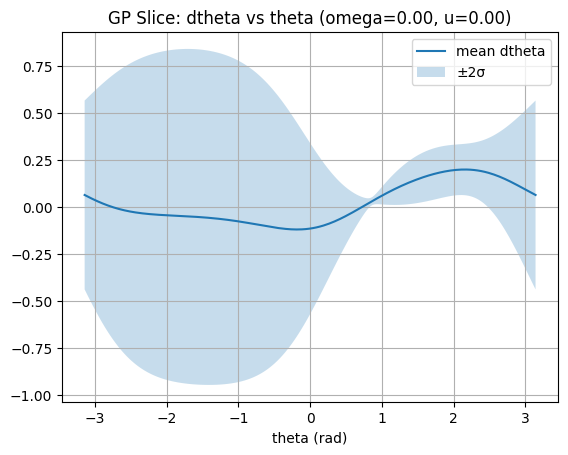

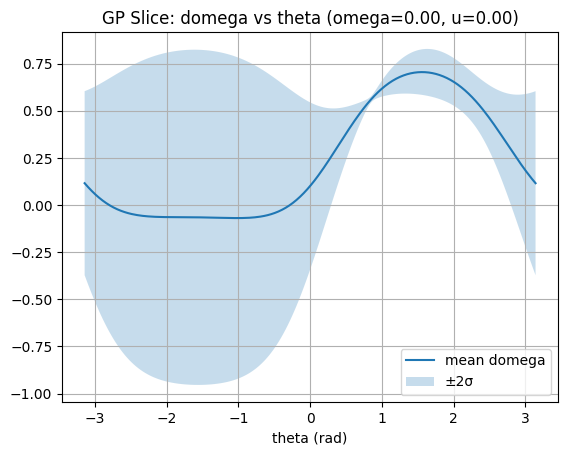

✅ Initial GP trained + slice plots shown.


In [14]:
# ===========================
# Cell 5 — Train initial OSGPR-VFE models (dtheta, domega) + cache + slice plots
#   - two independent single-output models
#   - start from PRIOR summary (no old data yet)
#   - build predict cache for MPPI speed
# ===========================

import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf

# ----------------------------
# Load initial random data
# ----------------------------
try:
    data = np.load("pendulum_gp_initial_data.npz")
    X0 = data["X"].astype(np.float64)
    Ydth0 = data["Ydtheta"].astype(np.float64).reshape(-1, 1)
    Ydom0 = data["Ydomega"].astype(np.float64).reshape(-1, 1)
    omega_scale = float(data["omega_scale"][0])
except Exception as e:
    raise RuntimeError("Could not load pendulum_gp_initial_data.npz — run Cell 3 first.") from e

mask = finite_mask(X0, Ydth0, Ydom0)
X0 = X0[mask]
Ydth0 = Ydth0[mask]
Ydom0 = Ydom0[mask]

print("Loaded initial dataset:")
print("  X0   :", X0.shape)
print("  Ydth :", Ydth0.shape)
print("  Ydom :", Ydom0.shape)
print("  omega_scale =", omega_scale)

# ----------------------------
# Model config
# ----------------------------
M =32                 # inducing points
TRAIN_ITERS = 100
LR = 0.02

# Initial inducing points from random subset of X0
rng = np.random.default_rng(0)
idx = rng.choice(X0.shape[0], size=min(M, X0.shape[0]), replace=False)
Z_init = X0[idx].copy()

# Kernel (same spirit as your notebook: simple & stable)
kernel = gpflow.kernels.SquaredExponential(lengthscales=np.ones(X0.shape[1], dtype=np.float64))
kernel.variance.assign(1.0)

# Likelihood noise init
sigma2_init = 1e-3

# ----------------------------
# PRIOR summaries (start streaming from prior)
# ----------------------------
mu0, Su0, Kaa0, Z0 = prior_summary(kernel, Z_init)

# ----------------------------
# Build initial streaming models
# ----------------------------
m_dth = OSGPR_VFE(
    data=(X0, Ydth0),
    kernel=kernel,
    mu_old=mu0,
    Su_old=Su0,
    Kaa_old=Kaa0,
    Z_old=Z0,
    Z=Z_init,
)
m_dom = OSGPR_VFE(
    data=(X0, Ydom0),
    kernel=kernel,
    mu_old=mu0,
    Su_old=Su0,
    Kaa_old=Kaa0,
    Z_old=Z0,
    Z=Z_init,
)

m_dth.likelihood.variance.assign(sigma2_init)
m_dom.likelihood.variance.assign(sigma2_init)

# Train both models (kernel trainable here — first fit)
print("\nTraining dtheta model...")
dt1, loss1 = train_osgpr(m_dth, iters=TRAIN_ITERS, lr=LR)
print(f"  done. time={dt1:.2f}s  final_loss={loss1:.4f}")

print("\nTraining domega model...")
dt2, loss2 = train_osgpr(m_dom, iters=TRAIN_ITERS, lr=LR)
print(f"  done. time={dt2:.2f}s  final_loss={loss2:.4f}")

# Build fast predict caches
m_dth.build_predict_cache()
m_dom.build_predict_cache()
print("\n✅ Predict caches built.")

# ----------------------------
# Quick slice plot helper (theta sweep at fixed omega,u)
# ----------------------------
def gp_predict_mu_std_fast(model, Xnew_np):
    Xtf = tf.convert_to_tensor(Xnew_np, dtype=gpflow.default_float())
    mu_tf, var_tf = model.predict_f_cached(Xtf, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var_tf.numpy().reshape(-1), 1e-12))
    return mu, std

def slice_plot_theta(
    m_dth, m_dom,
    omega_fixed=0.0,
    u_fixed=0.0,
    omega_scale=8.0,
    n=250,
):
    thetas = np.linspace(-np.pi, np.pi, n)
    Xs = np.zeros((n, 4), dtype=np.float64)
    for i, th in enumerate(thetas):
        Xs[i] = theta_omega_to_features(th, omega_fixed, u_fixed, omega_scale=omega_scale)

    mu_dth, std_dth = gp_predict_mu_std_fast(m_dth, Xs)
    mu_dom, std_dom = gp_predict_mu_std_fast(m_dom, Xs)

    plt.figure()
    plt.plot(thetas, mu_dth, label="mean dtheta")
    plt.fill_between(thetas, mu_dth - 2*std_dth, mu_dth + 2*std_dth, alpha=0.25, label="±2σ")
    plt.title(f"GP Slice: dtheta vs theta (omega={omega_fixed:.2f}, u={u_fixed:.2f})")
    plt.xlabel("theta (rad)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(thetas, mu_dom, label="mean domega")
    plt.fill_between(thetas, mu_dom - 2*std_dom, mu_dom + 2*std_dom, alpha=0.25, label="±2σ")
    plt.title(f"GP Slice: domega vs theta (omega={omega_fixed:.2f}, u={u_fixed:.2f})")
    plt.xlabel("theta (rad)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Run quick slice visualization
slice_plot_theta(
    m_dth, m_dom,
    omega_fixed=0.0,
    u_fixed=0.0,
    omega_scale=omega_scale,
    n=250,
)

print("✅ Initial GP trained + slice plots shown.")


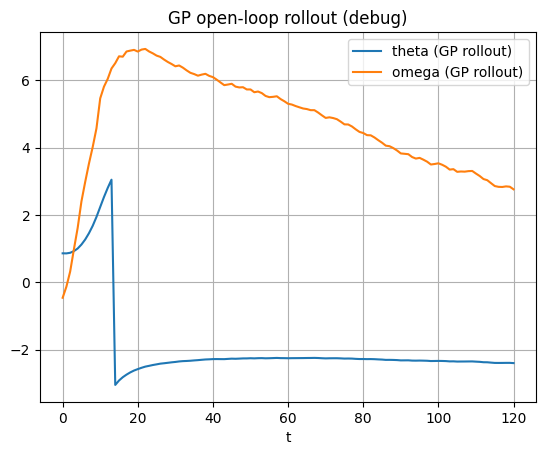

✅ Cell 6 ready: GP step + rollout works.


In [15]:
# =========================================================
# Cell 6 — GP dynamics step + rollout (FAST cached predictor)
#
# State:  (theta, omega)    [rad], [rad/s]
# Action: u in [U_MIN, U_MAX]
#
# GP input:  X = [sin(theta), cos(theta), omega_feat, u]
#   omega_feat = tanh(omega / omega_scale)
#
# GP output:
#   dtheta = model_dtheta(X)
#   domega = model_domega(X)
#
# Next:
#   theta_next = wrap(theta + dtheta)
#   omega_next = omega + domega
# =========================================================

import numpy as np
import tensorflow as tf
import gpflow

DTYPE = gpflow.default_float()

# ----------------------------
# safe wraps / clamps
# ----------------------------
def clamp_u(u):
    return float(np.clip(u, U_MIN, U_MAX))

def clamp_omega(omega, wmax=12.0):
    # Pendulum can spin fast; clamp helps keep GP rollouts stable for MPPI
    return float(np.clip(omega, -wmax, wmax))

# ----------------------------
# GP input builder (vectorized)
# ----------------------------
def make_gp_X(theta, omega, u, omega_scale):
    """
    theta: (...,)
    omega: (...,)
    u:     (...,)
    Returns X (...,4)
    """
    theta = np.asarray(theta, dtype=np.float64)
    omega = np.asarray(omega, dtype=np.float64)
    u     = np.asarray(u, dtype=np.float64)

    omega_feat = np.tanh(omega / float(omega_scale))
    X = np.stack([np.sin(theta), np.cos(theta), omega_feat, u], axis=-1).astype(np.float64)
    return X

# ----------------------------
# Fast single-step GP dynamics (batch)
# ----------------------------
def gp_step_batch_cached(m_dth, m_dom, theta, omega, u, omega_scale, return_unc=False):
    """
    Vectorized step for K particles.
    Inputs:
        theta, omega, u are arrays of shape (K,)
    Returns:
        theta2, omega2 (K,)
        (optional) unc (K,) combined uncertainty proxy
    """
    X = make_gp_X(theta, omega, u, omega_scale=omega_scale)
    Xtf = tf.convert_to_tensor(X, dtype=DTYPE)

    mu_dth, var_dth = m_dth.predict_f_cached(Xtf, full_cov=False)
    mu_dom, var_dom = m_dom.predict_f_cached(Xtf, full_cov=False)

    dth = mu_dth.numpy().reshape(-1)
    dom = mu_dom.numpy().reshape(-1)

    th2 = theta + dth
    th2 = np.array([wrap_pi(x) for x in th2], dtype=np.float64)

    om2 = omega + dom
    om2 = np.clip(om2, -12.0, 12.0)  # rollout stabilizer

    if return_unc:
        std_dth = np.sqrt(np.maximum(var_dth.numpy().reshape(-1), 1e-12))
        std_dom = np.sqrt(np.maximum(var_dom.numpy().reshape(-1), 1e-12))
        unc = np.sqrt(std_dth**2 + std_dom**2)  # simple combined uncertainty
        return th2, om2, unc

    return th2, om2

# ----------------------------
# GP rollout for visualization/debug
# ----------------------------
def gp_rollout_open_loop(m_dth, m_dom, theta0, omega0, U_seq, omega_scale):
    """
    Rollout GP dynamics using a provided open-loop action sequence.
    U_seq: (H,) actions in [U_MIN, U_MAX]
    Returns:
        theta_traj (H+1,)
        omega_traj (H+1,)
    """
    H = len(U_seq)
    th = float(theta0)
    om = float(omega0)

    th_traj = [th]
    om_traj = [om]

    for t in range(H):
        u = float(np.clip(U_seq[t], U_MIN, U_MAX))
        th2, om2 = gp_step_batch_cached(
            m_dth, m_dom,
            theta=np.array([th], dtype=np.float64),
            omega=np.array([om], dtype=np.float64),
            u=np.array([u], dtype=np.float64),
            omega_scale=omega_scale,
            return_unc=False
        )
        th = float(th2[0])
        om = float(om2[0])
        th_traj.append(th)
        om_traj.append(om)

    return np.array(th_traj), np.array(om_traj)

# ----------------------------
# Quick sanity test: compare a short GP rollout against random open-loop actions
# ----------------------------
H_test = 120
U_test = np.random.uniform(U_MIN, U_MAX, size=H_test)

# reset env for initial state
env_tmp = make_env(render_mode=None, seed=0)
obs, info = env_tmp.reset(seed=0)
theta0, omega0 = obs_to_theta_omega(obs)
env_tmp.close()

th_gp, om_gp = gp_rollout_open_loop(m_dth, m_dom, theta0, omega0, U_test, omega_scale)

plt.figure()
plt.plot(th_gp, label="theta (GP rollout)")
plt.plot(om_gp, label="omega (GP rollout)")
plt.title("GP open-loop rollout (debug)")
plt.xlabel("t")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Cell 6 ready: GP step + rollout works.")


In [16]:
# ===========================
# Cell 7 — MPPI planner (CACHED) + uncertainty bonus + time penalty (Pendulum)
#
# Explore:
#   maximize GP predictive uncertainty along rollout
#
# Exploit:
#   get upright fast:
#     running cost ~ time + small (theta^2 + omega^2)
#     terminal cost ~ bigger (theta^2 + omega^2)
#
# Output:
#   u0, u_nom_shifted, stats, u_candidates (for inducing coverage)
# ===========================

import numpy as np

# ----------------------------
# MPPI Hyperparams (defaults you can tune later)
# ----------------------------
HORIZON     = 30
NUM_SAMPLES = 96
NOISE_SIGMA = 0.6
LAMBDA      = 1.0

# exploitation weights
W_TIME   = 1.0
W_THETA  = 3.0
W_OMEGA  = 0.3
W_TERM   = 15.0

# exploration weights
W_UNC      = 1.5          # uncertainty bonus strength
UNC_SCALE  = 0.10         # normalize uncertainty
UNC_EVERY  = 1            # add unc every k steps

# action smoothing penalty (optional)
W_DU = 0.0   # set >0 if you want smoother actions


# ----------------------------
# Cost functions
# ----------------------------
def running_cost_exploit(theta, omega, u):
    """
    theta, omega, u: arrays shape (K,)
    """
    return (
        W_TIME
        + W_THETA * (theta**2)
        + W_OMEGA * (omega**2)
        + 0.0 * (u**2)
    )

def terminal_cost_exploit(theta, omega):
    return W_TERM * (theta**2 + 0.5 * omega**2)

def uncertainty_bonus(unc):
    """
    unc: array shape (K,)
    return negative cost (i.e., bonus)
    """
    return -W_UNC * (unc / UNC_SCALE)


# ----------------------------
# MPPI (vectorized)
# ----------------------------
def mppi_plan_action_uncertainty(
    m_dth,
    m_dom,
    theta0,
    omega0,
    u_nom,
    omega_scale,
    horizon=HORIZON,
    num_samples=NUM_SAMPLES,
    noise_sigma=NOISE_SIGMA,
    lam=LAMBDA,
    explore=True,
    rng=None,
):
    """
    Returns:
      u0,
      u_nom_shifted,
      info dict,
      u_candidates = U[:,0]
    """
    if rng is None:
        rng = np.random.default_rng(0)

    # ensure u_nom is shape (H,)
    u_nom = np.asarray(u_nom, dtype=np.float64).reshape(-1)
    if u_nom.shape[0] != horizon:
        u_nom = np.zeros(horizon, dtype=np.float64)

    # Sample noise and build action rollouts
    noise = rng.normal(0.0, noise_sigma, size=(num_samples, horizon)).astype(np.float64)
    U = u_nom[None, :] + noise
    U = np.clip(U, U_MIN, U_MAX)

    # Initialize particles
    theta = np.full((num_samples,), float(theta0), dtype=np.float64)
    omega = np.full((num_samples,), float(omega0), dtype=np.float64)

    # Cost per sample
    J = np.zeros((num_samples,), dtype=np.float64)

    # optional action smoothing
    if W_DU > 0.0:
        du = np.diff(U, axis=1, prepend=U[:, :1])
        J += W_DU * np.sum(du**2, axis=1)

    # rollout
    for t in range(horizon):
        u_t = U[:, t]

        if explore:
            theta2, omega2, unc = gp_step_batch_cached(
                m_dth, m_dom,
                theta=theta,
                omega=omega,
                u=u_t,
                omega_scale=omega_scale,
                return_unc=True,
            )
        else:
            theta2, omega2 = gp_step_batch_cached(
                m_dth, m_dom,
                theta=theta,
                omega=omega,
                u=u_t,
                omega_scale=omega_scale,
                return_unc=False,
            )
            unc = None

        # exploitation running cost
        J += running_cost_exploit(theta2, omega2, u_t)

        # exploration bonus
        if explore and (unc is not None) and ((t % UNC_EVERY) == 0):
            J += uncertainty_bonus(unc)

        # advance
        theta, omega = theta2, omega2

    # terminal cost
    J += terminal_cost_exploit(theta, omega)

    # MPPI weights
    beta = np.min(J)
    w = np.exp(-(J - beta) / float(lam))
    w = w / (np.sum(w) + 1e-12)

    # update nominal with weighted noise
    delta_u = np.sum(w[:, None] * noise, axis=0)   # (H,)
    u_nom_new = np.clip(u_nom + delta_u, U_MIN, U_MAX)

    # choose control
    u0 = float(u_nom_new[0])

    # shift nominal (warm start)
    u_nom_shifted = np.roll(u_nom_new, -1)
    u_nom_shifted[-1] = 0.0

    info = dict(
        J_min=float(np.min(J)),
        J_mean=float(np.mean(J)),
        u0=u0,
    )

    # candidate actions for inducing coverage trick
    u_candidates = U[:, 0].copy()

    return u0, u_nom_shifted, info, u_candidates


# ----------------------------
# Quick MPPI sanity test (no env execution yet)
# ----------------------------
u_nom = np.zeros(HORIZON, dtype=np.float64)

env_tmp = make_env(render_mode=None, seed=0)
obs, info = env_tmp.reset(seed=0)
theta0, omega0 = obs_to_theta_omega(obs)
env_tmp.close()

u0, u_nom, info, u_candidates = mppi_plan_action_uncertainty(
    m_dth, m_dom,
    theta0, omega0,
    u_nom=u_nom,
    omega_scale=omega_scale,
    horizon=HORIZON,
    num_samples=NUM_SAMPLES,
    noise_sigma=NOISE_SIGMA,
    lam=LAMBDA,
    explore=True,
    rng=np.random.default_rng(0),
)

print("MPPI sanity test:")
print("  u0 =", u0)
print("  info =", info)
print("  candidates:", u_candidates.shape, "range:", (u_candidates.min(), u_candidates.max()))


MPPI sanity test:
  u0 = -1.5200652938338435
  info = {'J_min': 1051.5853547866393, 'J_mean': 1135.1489627635076, 'u0': -1.5200652938338435}
  candidates: (96,) range: (-1.527542760219647, 1.6534845349655707)


[Update @ t=39] explore=True dth=0.68s dom=0.69s loss_th=-120.057 loss_om=-125.859 upd_wall=1.46s
   [Eval] success=True steps=62 wall=13.99s
[Update @ t=59] explore=True dth=0.94s dom=0.72s loss_th=-257.750 loss_om=-269.573 upd_wall=1.75s
   [Eval] success=False steps=400 wall=92.93s
[Update @ t=79] explore=True dth=0.73s dom=0.71s loss_th=-341.147 loss_om=-348.033 upd_wall=1.53s
   [Eval] success=False steps=400 wall=92.61s
[Update @ t=99] explore=True dth=0.73s dom=0.68s loss_th=-284.350 loss_om=-362.394 upd_wall=1.50s
   [Eval] success=True steps=63 wall=14.78s
[Update @ t=119] explore=False dth=0.71s dom=0.71s loss_th=-412.505 loss_om=-449.426 upd_wall=1.51s
   [Eval] success=True steps=65 wall=15.12s
[Update @ t=139] explore=False dth=0.73s dom=0.75s loss_th=-472.678 loss_om=-493.775 upd_wall=1.58s
   [Eval] success=True steps=82 wall=19.32s
[Update @ t=159] explore=False dth=0.73s dom=0.72s loss_th=-480.180 loss_om=-503.547 upd_wall=1.54s
   [Eval] success=True steps=67 wall=15.

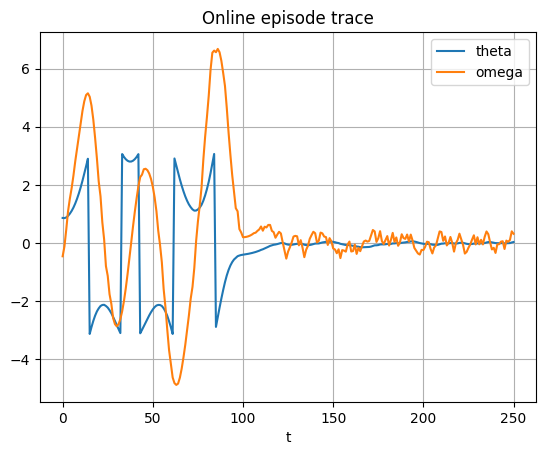

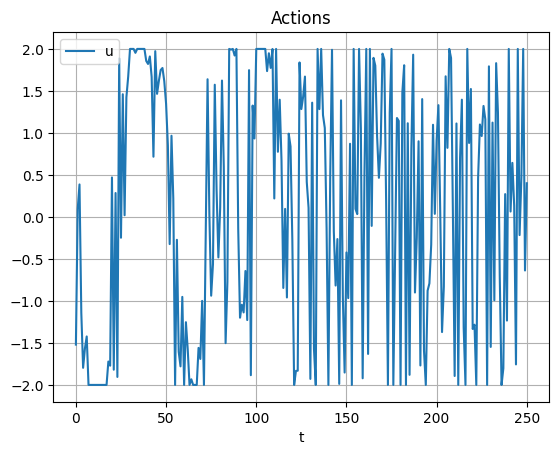

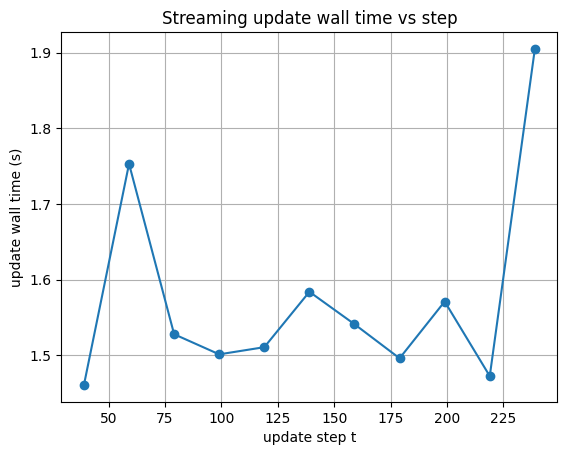

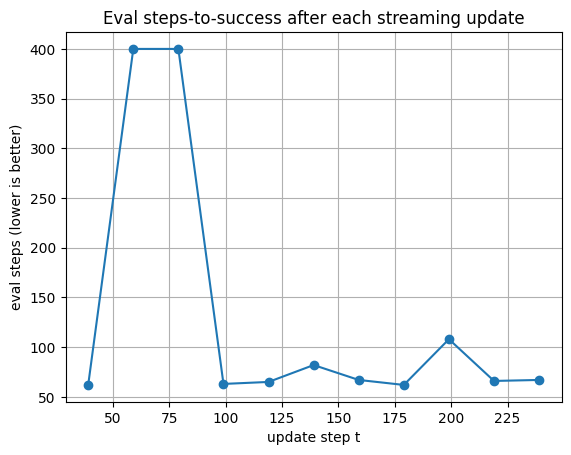

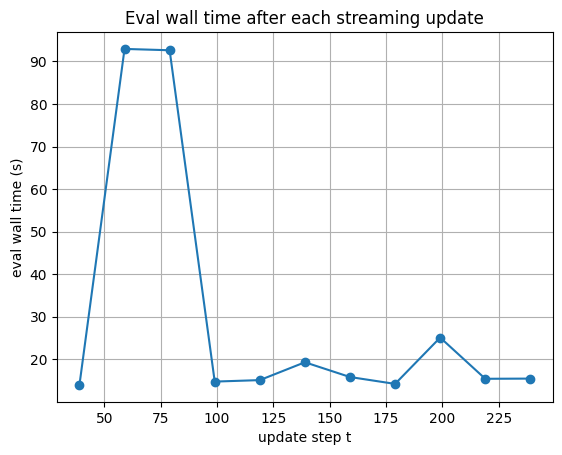

Eval success flags: [True, False, False, True, True, True, True, True, True, True, True]


In [17]:
# ===========================
# Cell 8 — ONLINE IN 1 EPISODE (UPDATED + FIXED):
#   MPPI (explore->exploit) + executed transitions + Streaming OSGPR-VFE updates
#   ✅ After EACH retrain/update: run 1 EVAL episode (exploit-only, NO retrain)
#   ✅ FIX: override Pendulum-v1 TimeLimit so "hold success for N steps" actually works
# ===========================

import numpy as np
import tensorflow as tf
import gpflow
import time
import matplotlib.pyplot as plt
from PIL import Image

from gymnasium.wrappers import TimeLimit

# ----------------------------
# ✅ TimeLimit override helper
# ----------------------------
def make_env_override(render_mode=None, seed=0, max_episode_steps=1000):
    """
    Correct override:
      gym.make(Pendulum-v1) already includes TimeLimit(200),
      so we unwrap it then apply our own TimeLimit(max_episode_steps).
    """
    env = gym.make(ENV_NAME, render_mode=render_mode)

    # ✅ unwrap existing time limit(s)
    while isinstance(env, TimeLimit):
        env = env.env

    # ✅ re-wrap with your desired horizon
    env = TimeLimit(env, max_episode_steps=max_episode_steps)

    env.reset(seed=seed)
    return env

# ----------------------------
# k-center inducing selection (your style)
# ----------------------------
def choose_Z_kcenter(Z_old, X_batch, M, X_mppi_cand=None, rng=None):
    """
    Build new inducing points Z_new using greedy k-center over a candidate set:
      candidates = [Z_old; X_batch; X_mppi_cand]
    """
    if rng is None:
        rng = np.random.default_rng(0)

    Z_old = np.asarray(Z_old, dtype=np.float64)
    X_batch = np.asarray(X_batch, dtype=np.float64)

    cand = [Z_old, X_batch]
    if X_mppi_cand is not None:
        X_mppi_cand = np.asarray(X_mppi_cand, dtype=np.float64)
        cand.append(X_mppi_cand)
    C = np.vstack(cand).astype(np.float64)

    if C.shape[0] <= M:
        return C.copy()

    first = int(rng.integers(0, C.shape[0]))
    Z = [C[first]]
    dist2 = np.sum((C - Z[0][None, :])**2, axis=1)

    for _ in range(1, M):
        idx = int(np.argmax(dist2))
        Z.append(C[idx])
        d2_new = np.sum((C - C[idx][None, :])**2, axis=1)
        dist2 = np.minimum(dist2, d2_new)

    return np.array(Z, dtype=np.float64)


# ----------------------------
# Streaming update wrapper (single model)
# ----------------------------
def streaming_update_once(model_old, X_batch, y_batch, Z_new, train_iters=220, lr=0.02, freeze_kernel=True):
    """
    model_old: OSGPR_VFE
    Build new OSGPR_VFE using old summary + batch data, with new inducing Z_new.
    """
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)
    kern = model_old.kernel

    model_new = OSGPR_VFE(
        data=(X_batch, y_batch),
        kernel=kern,
        mu_old=mu_old,
        Su_old=Su_old,
        Kaa_old=Kaa_old,
        Z_old=Z_old,
        Z=Z_new,
    )

    model_new.likelihood.variance.assign(model_old.likelihood.variance.numpy())

    if freeze_kernel:
        gpflow.set_trainable(model_new.kernel, False)

    dt, loss = train_osgpr(model_new, iters=train_iters, lr=lr)
    model_new.build_predict_cache()

    return model_new, dict(train_time=dt, loss=loss)


def make_mppi_candidate_cloud(theta_hist, omega_hist, u_candidates, omega_scale, S=64, rng=None):
    """
    Your trick:
      - sample recent executed states (theta, omega)
      - pair them with MPPI candidate first actions
      -> candidate X cloud used ONLY for inducing coverage
    """
    if rng is None:
        rng = np.random.default_rng(0)

    theta_hist = np.asarray(theta_hist, dtype=np.float64)
    omega_hist = np.asarray(omega_hist, dtype=np.float64)
    u_candidates = np.asarray(u_candidates, dtype=np.float64)

    if len(theta_hist) == 0:
        return None

    S = min(S, len(theta_hist))
    idxS = rng.choice(len(theta_hist), size=S, replace=False)
    a = rng.choice(u_candidates, size=S, replace=True)

    Xcand = np.zeros((S, 4), dtype=np.float64)
    for i, (th, om, u) in enumerate(zip(theta_hist[idxS], omega_hist[idxS], a)):
        Xcand[i] = theta_omega_to_features(th, om, float(u), omega_scale=omega_scale)
    return Xcand


# ----------------------------
# Success condition (upright + stable)
# ----------------------------
def is_success(theta, omega, theta_tol=0.12, omega_tol=0.5):
    return (abs(theta) < theta_tol) and (abs(omega) < omega_tol)


# ----------------------------
# ✅ Evaluation episode (exploit-only, NO updates)
# ----------------------------
def run_eval_episode(
    m_dth,
    m_dom,
    omega_scale,
    seed=123,
    max_steps=300,
    success_streak_need=50,
):
    """
    Evaluation = exploit-only MPPI, no exploration bonus, no GP updates.
    Returns dict: success, steps, wall
    """
    env = make_env_override(render_mode=None, seed=seed, max_episode_steps=max_steps)
    obs, info = env.reset(seed=seed)
    theta, omega = obs_to_theta_omega(obs)

    u_nom = np.zeros(HORIZON, dtype=np.float64)
    rng = np.random.default_rng(seed)

    success_streak = 0
    t0 = time.time()

    for t in range(max_steps):
        u, u_nom, info_mppi, _ = mppi_plan_action_uncertainty(
            m_dth, m_dom,
            theta0=theta,
            omega0=omega,
            u_nom=u_nom,
            omega_scale=omega_scale,
            horizon=HORIZON,
            num_samples=NUM_SAMPLES,
            noise_sigma=NOISE_SIGMA,
            lam=LAMBDA,
            explore=False,    # ✅ exploit only
            rng=rng,
        )

        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        theta, omega = obs_to_theta_omega(obs2)

        if is_success(theta, omega):
            success_streak += 1
        else:
            success_streak = 0

        if success_streak >= success_streak_need:
            env.close()
            return dict(success=True, steps=t+1, wall=time.time() - t0)

        if terminated or truncated:
            break

    env.close()
    return dict(success=False, steps=max_steps, wall=time.time() - t0)


# ----------------------------
# Online episode runner (UPDATED with eval after each update)
# ----------------------------
def run_online_episode_streaming(
    seed=0,
    max_steps=1000,
    render=True,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    # MPPI schedule
    explore_steps=100,
    # update schedule
    min_steps_before_update=20,
    update_every=20,
    online_batch=128,
    # inducing points
    M=32,
    mppi_cloud_S=32,
    # training
    train_iters=100,
    lr=0.02,
    freeze_kernel_after_init=True,
    # eval
    eval_seed=123,
    eval_max_steps=500,
    eval_success_streak_need=50,
):
    """
    Runs ONE real episode:
      - MPPI each step
      - store executed transitions only
      - periodic streaming updates inside the same episode
      ✅ after each update: run 1 eval episode exploit-only
    Returns logs and optional HTML animation.
    """
    rng = np.random.default_rng(seed)

    env = make_env_override(
        render_mode="rgb_array" if render else None,
        seed=seed,
        max_episode_steps=max_steps
    )
    obs, info = env.reset(seed=seed)
    theta, omega = obs_to_theta_omega(obs)

    u_nom = np.zeros(HORIZON, dtype=np.float64)

    X_exec = []
    y_dth_exec = []
    y_dom_exec = []
    theta_hist = []
    omega_hist = []
    u_hist = []

    update_logs = []

    success_streak = 0
    NEED_STREAK = 80

    frames = []

    global m_dth, m_dom

    t0 = time.time()

    for t in range(max_steps):
        theta_hist.append(theta)
        omega_hist.append(omega)

        explore = (t < explore_steps)

        # MPPI plan
        u, u_nom, info_mppi, u_candidates = mppi_plan_action_uncertainty(
            m_dth, m_dom,
            theta0=theta,
            omega0=omega,
            u_nom=u_nom,
            omega_scale=omega_scale,
            horizon=HORIZON,
            num_samples=NUM_SAMPLES,
            noise_sigma=NOISE_SIGMA,
            lam=LAMBDA,
            explore=explore,
            rng=rng,
        )

        # execute env step
        obs2, r, terminated, truncated, info = env.step(np.array([u], dtype=np.float32))
        theta2, omega2 = obs_to_theta_omega(obs2)

        # executed labels
        dtheta = wrap_pi(theta2 - theta)
        domega = float(omega2 - omega)

        # store executed sample
        X_exec.append(theta_omega_to_features(theta, omega, u, omega_scale=omega_scale))
        y_dth_exec.append(dtheta)
        y_dom_exec.append(domega)
        u_hist.append(u)

        # render frames
        if render and (t % frame_stride == 0):
            frame = env.render()
            if frame is not None:
                img = Image.fromarray(frame).resize(resize, resample=Image.BILINEAR)
                frames.append(np.array(img))

        # advance
        theta, omega = theta2, omega2

        # success streak
        if is_success(theta, omega):
            success_streak += 1
        else:
            success_streak = 0

        # -------------------------
        # periodic streaming update
        # -------------------------
        if (t >= min_steps_before_update) and ((t + 1) % update_every == 0):
            X_arr = np.array(X_exec, dtype=np.float64)
            yth_arr = np.array(y_dth_exec, dtype=np.float64).reshape(-1, 1)
            yom_arr = np.array(y_dom_exec, dtype=np.float64).reshape(-1, 1)

            Xb = X_arr[-online_batch:]
            yth_b = yth_arr[-online_batch:]
            yom_b = yom_arr[-online_batch:]

            # MPPI candidate cloud for inducing coverage
            Xcand = make_mppi_candidate_cloud(
                theta_hist=np.array(theta_hist, dtype=np.float64),
                omega_hist=np.array(omega_hist, dtype=np.float64),
                u_candidates=u_candidates,
                omega_scale=omega_scale,
                S=mppi_cloud_S,
                rng=rng,
            )

            # choose new inducing (k-center)
            Z_old_th = m_dth.inducing_variable.Z.numpy()
            Z_old_om = m_dom.inducing_variable.Z.numpy()
            Z_new_th = choose_Z_kcenter(Z_old_th, Xb, M=M, X_mppi_cand=Xcand, rng=rng)
            Z_new_om = choose_Z_kcenter(Z_old_om, Xb, M=M, X_mppi_cand=Xcand, rng=rng)

            # streaming update both models
            t_up = time.time()
            m_dth_new, log_th = streaming_update_once(
                m_dth, Xb, yth_b, Z_new_th, train_iters=train_iters, lr=lr,
                freeze_kernel=freeze_kernel_after_init
            )
            m_dom_new, log_om = streaming_update_once(
                m_dom, Xb, yom_b, Z_new_om, train_iters=train_iters, lr=lr,
                freeze_kernel=freeze_kernel_after_init
            )
            m_dth, m_dom = m_dth_new, m_dom_new
            update_wall = time.time() - t_up

            # ✅ EVAL immediately after update (exploit-only)
            eval_res = run_eval_episode(
                m_dth, m_dom,
                omega_scale=omega_scale,
                seed=eval_seed,
                max_steps=eval_max_steps,
                success_streak_need=eval_success_streak_need,
            )

            update_logs.append(dict(
                t=t,
                explore=explore,
                th_train_time=log_th["train_time"],
                om_train_time=log_om["train_time"],
                th_loss=log_th["loss"],
                om_loss=log_om["loss"],
                update_wall=update_wall,
                X_batch=len(Xb),
                eval_success=eval_res["success"],
                eval_steps=eval_res["steps"],
                eval_wall=eval_res["wall"],
            ))

            print(f"[Update @ t={t}] explore={explore} "
                  f"dth={log_th['train_time']:.2f}s dom={log_om['train_time']:.2f}s "
                  f"loss_th={log_th['loss']:.3f} loss_om={log_om['loss']:.3f} "
                  f"upd_wall={update_wall:.2f}s")
            print(f"   [Eval] success={eval_res['success']} steps={eval_res['steps']} wall={eval_res['wall']:.2f}s")

        # stop if stabilized
        if success_streak >= NEED_STREAK:
            print(f"✅ SUCCESS: upright stable for {NEED_STREAK} steps at t={t}.")
            break

        if terminated or truncated:
            break

    env.close()

    wall = time.time() - t0
    print(f"Episode finished. steps={t+1}, wall={wall:.2f}s, updates={len(update_logs)}")

    html = None
    if render and len(frames) > 0:
        html = _encode_frames_to_jshtml(frames, fps=fps)

    logs = dict(
        theta=np.array(theta_hist, dtype=np.float64),
        omega=np.array(omega_hist, dtype=np.float64),
        u=np.array(u_hist, dtype=np.float64),
        update_logs=update_logs,
        wall=wall,
        steps=t+1,
    )

    return logs, html


# ----------------------------
# Run 1 online episode (UPDATED)
# ----------------------------
logs, html = run_online_episode_streaming(
    seed=0,
    max_steps=650,
    render=True,          # set False for speed
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    explore_steps=100,
    min_steps_before_update=20,
    update_every=20,
    online_batch=128,
    M=32,
    mppi_cloud_S=32,
    train_iters=100,
    lr=0.02,
    freeze_kernel_after_init=True,
    eval_seed=123,
    eval_max_steps=400,
    eval_success_streak_need=30,
)

if html is not None:
    display(html)

# ----------------------------
# Plot episode traces
# ----------------------------
theta_tr = logs["theta"]
omega_tr = logs["omega"]
u_tr     = logs["u"]

plt.figure()
plt.plot(theta_tr, label="theta")
plt.plot(omega_tr, label="omega")
plt.title("Online episode trace")
plt.xlabel("t")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(u_tr, label="u")
plt.title("Actions")
plt.xlabel("t")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Plot update + eval metrics
# ----------------------------
if len(logs["update_logs"]) > 0:
    upd = logs["update_logs"]
    xs = [u["t"] for u in upd]

    plt.figure()
    plt.plot(xs, [u["update_wall"] for u in upd], marker="o")
    plt.title("Streaming update wall time vs step")
    plt.xlabel("update step t")
    plt.ylabel("update wall time (s)")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(xs, [u["eval_steps"] for u in upd], marker="o")
    plt.title("Eval steps-to-success after each streaming update")
    plt.xlabel("update step t")
    plt.ylabel("eval steps (lower is better)")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(xs, [u["eval_wall"] for u in upd], marker="o")
    plt.title("Eval wall time after each streaming update")
    plt.xlabel("update step t")
    plt.ylabel("eval wall time (s)")
    plt.grid(True)
    plt.show()

    print("Eval success flags:", [u["eval_success"] for u in upd])


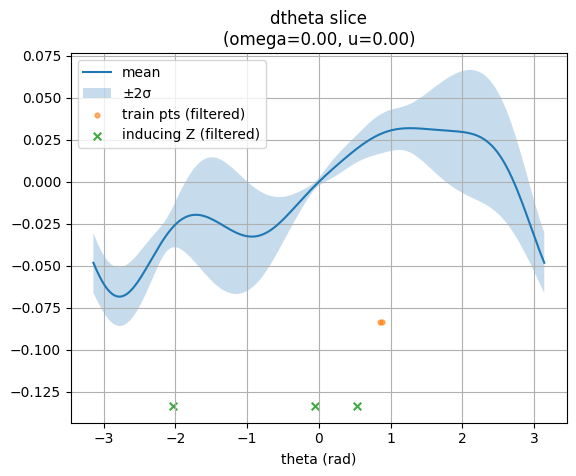

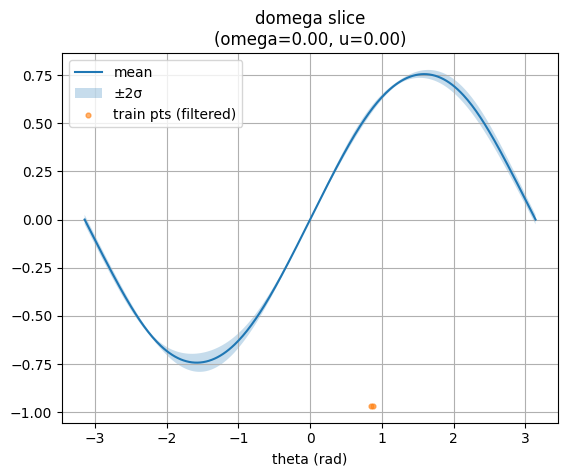

In [19]:
# ===========================
# Cell 9 — GP plotting (Slice + 3D Plotly surface) + inducing overlays
#   - Slice: mean ±2σ vs theta (fixed omega,u)
#   - 3D surface: mean(theta, omega) colored by std (fixed u)
#   - Overlay inducing points on both
# ===========================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gpflow

# --- Plotly (interactive 3D) ---
try:
    import plotly.graph_objects as go
    _PLOTLY_OK = True
except Exception as e:
    _PLOTLY_OK = False
    print("Plotly not available:", e)


# ----------------------------
# Decode helper: X=[sinθ, cosθ, ω_feat, u] -> (θ, ω, u)
# ----------------------------
def decode_X_to_theta_omega_u(X, omega_scale):
    """
    X: (N,4) with columns [sinθ, cosθ, ω_feat=tanh(ω/scale), u]
    Return:
      theta in (-pi,pi], omega approx, u
    """
    X = np.asarray(X, dtype=np.float64)
    s = X[:, 0]
    c = X[:, 1]
    wf = np.clip(X[:, 2], -0.999999, 0.999999)
    u  = X[:, 3]
    theta = np.arctan2(s, c)
    theta = np.array([wrap_pi(x) for x in theta], dtype=np.float64)
    omega = float(omega_scale) * np.arctanh(wf)
    return theta, omega, u


def gp_predict_mu_std_fast(model, Xnew_np):
    """
    Uses your cached predictor:
      model.predict_f_cached(Xnew)
    """
    Xtf = tf.convert_to_tensor(Xnew_np, dtype=gpflow.default_float())
    mu_tf, var_tf = model.predict_f_cached(Xtf, full_cov=False)
    mu = mu_tf.numpy().reshape(-1)
    std = np.sqrt(np.maximum(var_tf.numpy().reshape(-1), 1e-12))
    return mu, std


# ----------------------------
# Slice plot: output vs theta (fixed omega,u)
# with training + inducing overlays filtered by omega/u tolerance
# ----------------------------
def plot_gp_slice_theta(
    model,
    omega_scale,
    title="GP Slice",
    omega_fixed=0.0,
    u_fixed=0.0,
    n=320,
    # overlay datasets
    X_train=None,
    X_inducing=None,
    omega_tol=0.5,
    u_tol=0.35,
):
    thetas = np.linspace(-np.pi, np.pi, n)

    Xs = np.zeros((n, 4), dtype=np.float64)
    for i, th in enumerate(thetas):
        Xs[i] = theta_omega_to_features(th, omega_fixed, u_fixed, omega_scale=omega_scale)

    mu, std = gp_predict_mu_std_fast(model, Xs)

    plt.figure()
    plt.plot(thetas, mu, label="mean")
    plt.fill_between(thetas, mu - 2*std, mu + 2*std, alpha=0.25, label="±2σ")
    plt.title(f"{title}\n(omega={omega_fixed:.2f}, u={u_fixed:.2f})")
    plt.xlabel("theta (rad)")
    plt.grid(True)

    # ----------------------------
    # Overlay training points (as theta markers) filtered by omega/u proximity
    # ----------------------------
    y_base = float(np.min(mu) - 0.15 * (np.max(mu) - np.min(mu) + 1e-9))

    if X_train is not None:
        th_tr, om_tr, u_tr = decode_X_to_theta_omega_u(np.asarray(X_train), omega_scale)
        m = (np.abs(om_tr - omega_fixed) < omega_tol) & (np.abs(u_tr - u_fixed) < u_tol)
        if np.any(m):
            plt.scatter(
                th_tr[m],
                np.full(np.sum(m), y_base),
                s=12,
                alpha=0.6,
                label="train pts (filtered)",
            )

    # ----------------------------
    # Overlay inducing points (as theta markers) filtered by omega/u proximity
    # ----------------------------
    if X_inducing is not None:
        th_z, om_z, u_z = decode_X_to_theta_omega_u(np.asarray(X_inducing), omega_scale)
        m = (np.abs(om_z - omega_fixed) < omega_tol) & (np.abs(u_z - u_fixed) < u_tol)
        if np.any(m):
            plt.scatter(
                th_z[m],
                np.full(np.sum(m), y_base - 0.05),
                s=30,
                marker="x",
                alpha=0.9,
                label="inducing Z (filtered)",
            )

    plt.legend()
    plt.show()


# ----------------------------
# 3D Surface: mean(theta, omega) colored by std (fixed u)
# + overlay inducing points on surface
# ----------------------------
def plot_surface_mean_colored_by_std_interactive(
    model,
    omega_scale,
    title="GP Surface",
    u_fixed=0.0,
    theta_lim=(-np.pi, np.pi),
    omega_lim=(-8.0, 8.0),
    n_theta=80,
    n_omega=60,
    X_inducing=None,
):
    if not _PLOTLY_OK:
        print("Plotly not available. Install plotly to use interactive 3D surface.")
        return None

    th = np.linspace(theta_lim[0], theta_lim[1], n_theta)
    om = np.linspace(omega_lim[0], omega_lim[1], n_omega)

    TH, OM = np.meshgrid(th, om)  # (n_omega, n_theta)
    Xgrid = np.zeros((TH.size, 4), dtype=np.float64)

    k = 0
    for i in range(TH.shape[0]):
        for j in range(TH.shape[1]):
            Xgrid[k] = theta_omega_to_features(TH[i, j], OM[i, j], u_fixed, omega_scale=omega_scale)
            k += 1

    mu, std = gp_predict_mu_std_fast(model, Xgrid)
    MU = mu.reshape(TH.shape)
    STD = std.reshape(TH.shape)

    fig = go.Figure()

    fig.add_trace(
        go.Surface(
            x=TH,
            y=OM,
            z=MU,
            surfacecolor=STD,
            colorbar=dict(title="std"),
            name="mean surface",
            showscale=True,
            opacity=0.95,
        )
    )

    # overlay inducing points
    if X_inducing is not None:
        Z = np.asarray(X_inducing, dtype=np.float64)
        th_z, om_z, u_z = decode_X_to_theta_omega_u(Z, omega_scale)

        # show only inducing points close to the chosen u_fixed (otherwise it’s clutter)
        m = np.abs(u_z - u_fixed) < 0.35
        if np.any(m):
            # compute z-value at inducing points for placement
            mu_z, _ = gp_predict_mu_std_fast(model, Z[m])
            fig.add_trace(
                go.Scatter3d(
                    x=th_z[m],
                    y=om_z[m],
                    z=mu_z,
                    mode="markers",
                    marker=dict(size=4),
                    name="inducing points",
                )
            )

    fig.update_layout(
        title=f"{title} (fixed u={u_fixed:.2f})",
        scene=dict(
            xaxis_title="theta",
            yaxis_title="omega",
            zaxis_title="mean",
        ),
        margin=dict(l=0, r=0, t=40, b=0),
    )
    fig.show()
    return fig


# ============================================================
# Example usage right now (initial models):
#   - slice plots for dtheta and domega
#   - 3D surface for dtheta (colored by std)
# ============================================================

# you can pass X0 as train overlay and m_dth.inducing_variable.Z as inducing overlay
Zth = m_dth.inducing_variable.Z.numpy()
Zom = m_dom.inducing_variable.Z.numpy()

plot_gp_slice_theta(
    m_dth, omega_scale,
    title="dtheta slice",
    omega_fixed=0.0,
    u_fixed=0.0,
    X_train=X0,
    X_inducing=Zth,
    omega_tol=0.7,
    u_tol=0.45,
)

plot_gp_slice_theta(
    m_dom, omega_scale,
    title="domega slice",
    omega_fixed=0.0,
    u_fixed=0.0,
    X_train=X0,
    X_inducing=Zom,
    omega_tol=0.7,
    u_tol=0.45,
)

# 3D surfaces (fixed u)
plot_surface_mean_colored_by_std_interactive(
    m_dth, omega_scale,
    title="dtheta mean surface colored by std",
    u_fixed=0.0,
    theta_lim=(-np.pi, np.pi),
    omega_lim=(-8.0, 8.0),
    n_theta=90,
    n_omega=70,
    X_inducing=Zth,
)

plot_surface_mean_colored_by_std_interactive(
    m_dom, omega_scale,
    title="domega mean surface colored by std",
    u_fixed=0.0,
    theta_lim=(-np.pi, np.pi),
    omega_lim=(-8.0, 8.0),
    n_theta=90,
    n_omega=70,
    X_inducing=Zom,
)
